In [1]:
from sklearn.preprocessing import LabelEncoder

def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

def format_features(df):
    df['Cabin']= df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

# ch3. 평가

#### 성능 평가 지표(이진분류)
  이진/멀티 분류에 모두 적용되긴 하지만, 이진 분류에서 중요하게 강조
* 정확도(Accuracy)
* 오차행렬(Confusion Matrix)
* 정밀도(Precision)
* 재현율(Recall)
* F1 score
* ROC AUC

## 01 정확도 (Accuaray)
정확도 : 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표

**정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수**

* 직관적으로 모델 예측 성능을 나타냄
* 이진 분류의 경우, 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만으로 성능을 평가하지 않음

In [2]:
from sklearn.base import BaseEstimator

In [3]:
class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
            
        return pred

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

In [5]:
# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print("Dummy Classifier의 정확도는: {0:.4f}".format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


* 정확도는 불균형한 레이블 값 분포에서 ML모델의 성능을 판단할 경우, 적합한 평가 지표가 아님
100개의 데이터가 있고 이 중 90개의 데이터 레이블이 0, 10개의 데이터 레이블이 1이라고 한다면 무조건 0을 예측 결과로 반환하는 ML 모델의 경우 정확도가 90%가 됨

* MNIST 데이터 세트 : 0-9까지의 숫자 이미지의 픽셀 정보를 가지고 있음.
레이블이 7인 것만 True, 나머지 값은 모두 False. 즉, 전체 데이터의 10%만 true이고, 나머지 90%는 false인 불균형한 데이터세트로 변형

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 x 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 true이고 이를 astype(int)로 1로 변환, 7번이 아니면 false이고 0으로 변환
y = (digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 11)

In [7]:
# 불균형한 레이블 데이터 분포도 확인
print("레이블 테스트 세트 크기 :", y_test.shape)
print("테스트 세트 레이블 0과 1의 분포도")
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print("모든 예측을 0으로 하여도 정확도는:{:.3f}".format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


## 02 오차 행렬 (Confusion Matrix)

**학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는가를 함께 보여주는 지표**

* 예측 오류와, 예측 오류의 유형을 함께 보여줌
* 4분면의 행렬에서, 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지 나타냄


* 예측된 클래스 값 : 왼쪽(Negative)-오른쪽(Positive)
* 실제 클래스 값 : 위쪽(Negative)-아래쪽(Positive)
* T/F : 예측값이 실제값과 같은가/틀린가
* N/P : 예측결과값이 부정(0)/긍정(1)

TN | FP  
ㅡㅡㅡㅡ  
FN | TP

* TN : 예측값을 Negative값 0으로 예측했고, 실제 값 역시 Negative값 0
* FP : 예측값을 Positive값 1로 예측했고, 실제 값은 Negative값 0
* FN : 예측값을 Negative값 0으로 예측했고, 실제 값은 Positive값 1
* TP : 예측값을 Positive값 1로 예측했고, 실제 값 역시 Positive값 1

In [8]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

TP/TN/FP/FN : Classifier 성능의 여러 면모를 판달할 수 있는 기반 정보를 제공함, Accuracy, Precisioni, Recall 값을 계산할 수 있음  
**정확도 = 예측 결과와 실제 값이 동일한 건수 / 전체 데이터 수 = (TN+TP)/(TN+FP+FN+TP)**


일반적으로 불균형한 레이블 클래스를 가지는 이진분류모델에서는 많은 데이터 중에서 중점적으로 찾아야하는 매우 적은 수의 결과값에 positive를 설정해 1값을 부여하고, 그렇지 않은 경우 negative로 0값을 부여함

## 03 정밀도와 재현율
positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표

* 정밀도 = TP / (FP+TP)
Positive로 예측한 대상 중에 실제 값이 Positive로 일치한 데이터 비율  
precision_score()  


* 재현율 = TP / (FN+TP)
실제 값이 Positive인 대상 중에 실제 값이 Positive로 일치한 데이터의 비율  
recall_score()  

서로 보완적인 지표로 분류의 성능을 평가하는데 적용됨

**재현율이 중요 지표인 경우 : 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우**  
ex) 암 판단 모델, 금융 사기 적발 모델  
**정밀도가 중요 지표인 경우 : 실제 Negative 음성 데이터를 Positive로 잘못 판단하게 되면 업무상 큰 영향을 미치는 경우**  
ex) 스팸 메일

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    print("오차 행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}".format(accuracy, precision, recall))

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv("./train.csv")
y_titanic_df = titanic_df["Survived"]
X_titanic_df = titanic_df.drop("Survived", axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.20, random_state = 11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


C:\Users\gunso\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 정밀도/재현율 tradeoffs

일반적으로 이진 분류에서는 임곗값을 0.5, 즉 50%로 정하고 이 기준 값보다 확률이 크면 Positive, 작으면 Negative로 결정함

predict_proba() : 개별 데이터별로 예측확률을 반환함, 학습이 완료된 사이킷런 Classifier 객체에서 호출이 가능하며 테스트 피처 데이터 세트를 파라미터로 입력해주면 테스트 피처 레코드의 개별 클래스의 예측 확률을 반환함

In [11]:
import numpy as np

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print("pred_proba()결과 Shape: {0}".format(pred_proba.shape))
print("pred_proba array에서 앞 3개만 샘플로 추출 \n:", pred_proba[:3])

# 예측 확률 array와 예측 결과값 array를 병합(concatenate)해 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print("두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n", pred_proba_result[:3])

pred_proba()결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.4616653  0.5383347 ]
 [0.87862763 0.12137237]
 [0.87727002 0.12272998]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.4616653  0.5383347  1.        ]
 [0.87862763 0.12137237 0.        ]
 [0.87727002 0.12272998 0.        ]]


#### Binarizer 클래스 사용법

In [12]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2], [2, 0, 0], [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환함
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


#### predict_proba()를 이용해 predict()함수 구현하기

In [13]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 column, 즉 positive class 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [14]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값.
custom_threshold = 0.4

# predict_proba() 반환값의 두 번째 column, 즉 positive class 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361


임계값을 0.5->0.4로 낮추니 재현율 상승, 정밀도 하락  
: positive 예측을 너그럽게 하기 때문에 임곗값을 낮출 수록 ture가 많아지게 됨.

In [15]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds lists 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print("임곗값:", custom_threshold)
        get_clf_eval(y_test, custom_predict)
        print("")

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361

임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033

임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869

임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541

임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377



#### precision_recall_curve() API

In [16]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print("반환된 분류 결정 임곗값 배열의 Shape:", thresholds.shape)

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print("샘플 추출을 위한 임계값 배열의 index 10개:", thr_index)
print("샘플용 10개의 임곗값:", np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print("샘플 임계값별 정밀도: ", np.round(precisions[thr_index], 3))
print("샘플 임계값별 재현율: ", np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값: [0.1  0.12 0.14 0.19 0.28 0.4  0.57 0.67 0.82 0.95]
샘플 임계값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


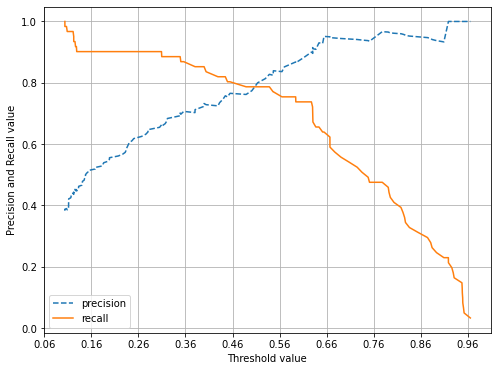

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 다른 정밀도, 재현율 ndarray 추출
    precision, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # x축을 threshold값으로, y축을 정밀도와 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precision[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 x축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축과 y축 label과 legend, 그리고 grid 설정
    plt.xlabel("Threshold value"); plt.ylabel("Precision and Recall value")
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

## 04 F1 score

정밀도와 재현율을 결합한 지표로, 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐

* F1 = 2 * (precision * recall) / (precision + recall)

In [18]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print("F1 스코어: {0:.4f}".format(f1))

F1 스코어: 0.7805


In [19]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    print("오차 행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}".format(accuracy, precision, recall, f1))

In [20]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361, F1: 0.7786

임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840

임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805

임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931

임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036



## 05 ROC 곡선과 AUC

ROC 곡선(Receiver Operation Characteristic Curve)과 이에 기반한 AUC 스코어  
이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표  


* FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지 나타내는 곡선
* x축: FPR, y축: TPR  

* TPR(재현율, 민감도) : 실제값 Positive가 정확히 예측돼야 하는 수준을 나타냄
* TNR(특이성) : 실제값 Negative가 정확히 예측돼야 하는 수준을 나타냄

TNR = TN / (FP + TN)  
FPR = FP / (FP + TN) = 1-TNR

ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화 값을 구함  
* FPR이 0이 되는 경우 : 임계값을 1로 설정, FP가 0이 됨
* FPR이 1이 되는 경우 : 임계값을 0으로 설정, TN이 0이 됨  
임계값을 1부터 0까지 변화시키면서 FPR을 구하고, 이 FPR 값의 변화에 따른 TPR 값을 구하는 것이 ROC 곡선임

In [21]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출
# thresholds[0]은 max(예측확률)+1로 임의설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print("샘플 추출을 위한 임곗값 배열의 index:", thr_index)
print("샘플 index로 추출한 임곗값: ", np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print("샘플 임곗값별 FPR: ", np.round(fprs[thr_index], 3))
print("샘플 임곗값별 TPR: ", np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값:  [0.97 0.65 0.63 0.57 0.45 0.38 0.31 0.13 0.12 0.11 0.1 ]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.186 0.237 0.576 0.619 0.754 0.814]
샘플 임곗값별 TPR:  [0.033 0.639 0.705 0.754 0.803 0.852 0.902 0.902 0.951 0.967 1.   ]


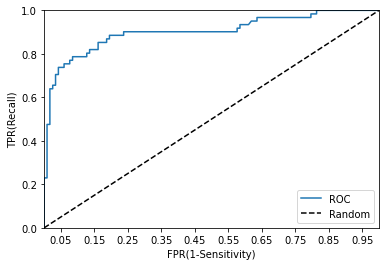

In [22]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    # ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label = "ROC")
    
    # 가운데 대각선 직선을 그림.
    plt.plot([0, 1], [0, 1], 'k--', label = "Random")
    
    
    # FPR x축의 scale을 0.1 단위로 변경, x, y축명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel("FPR(1-Sensitivity)"); plt.ylabel("TPR(Recall)")
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])

**AUC(Area Under Curve) : ROC 곡선 밑의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치**  
* 일반적으로 1에 가까울수록 좋은 수치
* AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건
* 가운데 직선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 곡선이 이동할수록 직사각형에 가까운 곡선이 되어 면적이 1에 가까워지는 좋은 ROC AUC 성능 수치를 얻게 됨.

In [23]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print("ROC AUC 값: {0: .4f}".format(roc_score))

ROC AUC 값:  0.9024


In [24]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print("오차 행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}".format(accuracy, precision, recall, f1, roc_auc))

In [25]:
get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805, AUC:0.9024
